In [1]:
import pandas as pd

import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)

# URL of the page containing the table
url = 'https://fplform.com/fpl-player-data'

# Use pandas to read HTML tables from the webpage
tables = pd.read_html(url)

# Assuming you want the first table on the page
df = tables[0]

# Set the 'ID' column as the index
df.set_index('ID', inplace=True)

# Display the first few rows of the table
df.head()

df.to_csv('fpl_player_data.csv')

In [2]:
df.columns

Index(['Name', 'Position', 'Team', 'Current Price', 'Total Points',
       'Points Per Game', 'Event Points', 'Form', 'Value Form', 'EP Next',
       'ICT Index', 'BPS', 'Penalties Order', 'Direct Freekick Order',
       'Corners/ Indirect Order', 'Chance Of Playing', 'Availability', 'News',
       'Selected By Percent', 'Transfers In', 'Transfers In Event',
       'Transfers Out', 'Transfers Out Event', 'Minutes', 'Goals Scored',
       'Assists', 'Clean Sheets', 'Goals Conceded', 'Goals Conceded per 90',
       'Own Goals', 'Penalties Saved', 'Penalties Missed', 'Yellow Cards',
       'Red Cards', 'Saves', 'Bonus', 'Influence', 'Creativity', 'Threat',
       'In Dreamteam', 'News Added', 'Fetched From FPL (London time)'],
      dtype='object')

In [3]:
df.shape

(684, 42)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 684 entries, 328 to 266
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Name                            684 non-null    object 
 1   Position                        684 non-null    object 
 2   Team                            684 non-null    object 
 3   Current Price                   684 non-null    float64
 4   Total Points                    684 non-null    int64  
 5   Points Per Game                 684 non-null    float64
 6   Event Points                    684 non-null    int64  
 7   Form                            684 non-null    float64
 8   Value Form                      684 non-null    float64
 9   EP Next                         684 non-null    float64
 10  ICT Index                       684 non-null    float64
 11  BPS                             684 non-null    int64  
 12  Penalties Order                 50

#### Combining direct freekick order and penalties order to one boolean column and dropping the other two columns

In [5]:
df['Direct_Freekick_or_Penalty'] = df[['Penalties Order', 'Direct Freekick Order']].notnull().any(axis=1).astype(int)
df = df.drop(['Penalties Order', 'Direct Freekick Order'], axis=1)

#### Converting 'Indirect_Freekick_or_Corner' to a boolean column and dropping the existing column

In [6]:
df['Indirect_Freekick_or_Corner'] = df[['Corners/ Indirect Order']].notnull().any(axis=1).astype(int)
df = df.drop(['Corners/ Indirect Order'], axis=1)

#### Adding a point adder system because during the season, fantasy football players will be allocated points based on their performance in the Premier League.

In [7]:
df['Clean Sheet Adder'] = df['Position'].apply(lambda x: 4 if x in ['Goalkeeper', 'Defender'] else (1 if x == 'Midfielder' else 0))

In [8]:
df['Goal Scored Adder'] = df['Position'].apply(lambda x: 10 if x == 'Goalkeeper' else 
                                               (6 if x == 'Defender' else 
                                                (5 if x == 'Midfielder' else 
                                                 (4 if x == 'Forward' else 0))))

In [9]:
df['Assists Adder'] = 3
df['Penalty Missed Adder'] = -2
df['Penalties Saved Adder'] = 5
df['3_Shot Save Adder'] = df.apply(lambda row: (row['Saves'] // 3) if row['Position'] == 'Goalkeeper' else 0, axis=1)
df['2_Goals Conceded Adder'] = df.apply(lambda row: -(row['Goals Conceded'] // 2) if row['Position'] in ['Goalkeeper', 'Defender'] else 0, axis=1)

In [10]:
df['Yellow Card Adder'] = -1
df['Red Card Adder'] = -3 
df['Own Goal Adder'] = -2 

#### Extracting the reason and date of comeback(if available) as chance of playing is already available in a seperate column, 'Chance of playing'. We also drop the column 'Availability'.

In [11]:
import re

def extract_reason_and_date(news):
    if pd.isna(news):
        return np.nan
    # Regular expression to find the reason and optional comeback date
    match = re.search(r'(.+?) - (.*?)(?=\d{1,2} \w{3}|$)', news)
    if match:
        reason = match.group(1).strip()
        # Check if there's a comeback date
        comeback_date_match = re.search(r'(\d{1,2} \w{3})', news)
        if comeback_date_match:
            return f"{reason} - Expected back {comeback_date_match.group(0)}"
        return reason
    return np.nan

# Create the new column
df['News'] = df['News'].apply(extract_reason_and_date)
df['News'] = df['News'].fillna('No news')

In [12]:
df = df.drop(['Availability'], axis = 1)

#### Converting the news added column to Days since news added as it gives a better insight.

In [13]:
from datetime import datetime
def days_since_added(news_added):
    if pd.isna(news_added):
        return np.nan
    current_year = datetime.now().year
    news_date_str = f"{news_added} {current_year}"
    news_date = pd.to_datetime(news_date_str, format='%a %b %d, %H:%M %Y')
    days_difference = (datetime.now() - news_date).days
    return days_difference

df['Days Since News Added'] = df['News Added'].apply(days_since_added)

#### Dropping columns that are not required and rearranging the columns so it makes more sense.

In [14]:
columns_to_drop = ['Value Form','Transfers In','Transfers In Event', 'Transfers Out', 'Transfers Out Event', 'In Dreamteam','News Added','Fetched From FPL (London time)']
df.drop(columns=columns_to_drop, inplace=True)

In [15]:
new_column_order = [
    'Name', 'Position', 'Team', 'Current Price', 'Total Points',
    'Points Per Game', 'Event Points', 'Form', 'Influence', 'Creativity', 'Threat', 'ICT Index', 
    'BPS', 'Chance Of Playing', 'News', 'Days Since News Added', 'Selected By Percent', 
    'Minutes', 'Goals Scored', 'Assists', 'Clean Sheets',
    'Goals Conceded', 'Goals Conceded per 90', 'Own Goals',
    'Penalties Saved', 'Penalties Missed', 'Yellow Cards', 'Red Cards',
    'Saves', 'Bonus', 
    'Direct_Freekick_or_Penalty', 'Indirect_Freekick_or_Corner',
    'Clean Sheet Adder', 'Goal Scored Adder', 'Assists Adder',
    'Penalty Missed Adder', 'Penalties Saved Adder', '3_Shot Save Adder',
    '2_Goals Conceded Adder', 'Yellow Card Adder', 'Red Card Adder',
    'Own Goal Adder', 'EP Next'
]


df = df[new_column_order]

In [16]:
df.head()

,Name,Position,Team,Current Price,Total Points,Points Per Game,Event Points,Form,Influence,Creativity,Threat,ICT Index,BPS,Chance Of Playing,News,Days Since News Added,Selected By Percent,Minutes,Goals Scored,Assists,Clean Sheets,Goals Conceded,Goals Conceded per 90,Own Goals,Penalties Saved,Penalties Missed,Yellow Cards,Red Cards,Saves,Bonus,Direct_Freekick_or_Penalty,Indirect_Freekick_or_Corner,Clean Sheet Adder,Goal Scored Adder,Assists Adder,Penalty Missed Adder,Penalties Saved Adder,3_Shot Save Adder,2_Goals Conceded Adder,Yellow Card Adder,Red Card Adder,Own Goal Adder,EP Next
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
328,M.Salah,Midfielder,Liverpool,13.1,120,10.0,13,11.5,543.6,293.0,668.0,150.3,392,100,No news,NaN,54.2,1054,10,6,6,8,0.68,0,0,0,1,0,0,23,1,0,1,5,3,-2,5,0,0,-1,-3,-2,11.5
182,Palmer,Midfielder,Chelsea,10.9,86,7.2,2,4.2,439.0,421.6,297.0,115.9,369,100,No news,12.0,54.7,1045,7,5,2,14,1.21,0,0,0,3,0,0,13,1,1,1,5,3,-2,5,0,0,-1,-3,-2,4.7
351,Haaland,Forward,Man City,15.1,84,7.0,2,3.8,456.0,91.9,804.0,135.4,376,100,No news,72.0,58.2,1079,12,0,2,17,1.42,0,0,0,2,0,0,14,1,0,0,4,3,-2,5,0,0,-1,-3,-2,3.8
17,Saka,Midfielder,Arsenal,10.2,80,7.3,13,6.5,398.0,457.4,457.0,131.1,325,100,No news,13.0,27.2,902,4,8,4,9,0.90,0,0,0,2,0,0,13,1,1,1,5,3,-2,5,0,0,-1,-3,-2,7.5
99,Mbeumo,Midfielder,Brentford,7.9,79,6.6,3,6.5,413.6,325.2,260.0,100.1,308,100,No news,11.0,41.1,1075,8,1,2,20,1.67,0,0,0,2,0,0,12,1,1,1,5,3,-2,5,0,0,-1,-3,-2,6.5


In [17]:
df.to_csv('fpl_player_data_clean_1.csv')

In [18]:
df

,Name,Position,Team,Current Price,Total Points,Points Per Game,Event Points,Form,Influence,Creativity,Threat,ICT Index,BPS,Chance Of Playing,News,Days Since News Added,Selected By Percent,Minutes,Goals Scored,Assists,Clean Sheets,Goals Conceded,Goals Conceded per 90,Own Goals,Penalties Saved,Penalties Missed,Yellow Cards,Red Cards,Saves,Bonus,Direct_Freekick_or_Penalty,Indirect_Freekick_or_Corner,Clean Sheet Adder,Goal Scored Adder,Assists Adder,Penalty Missed Adder,Penalties Saved Adder,3_Shot Save Adder,2_Goals Conceded Adder,Yellow Card Adder,Red Card Adder,Own Goal Adder,EP Next
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
328,M.Salah,Midfielder,Liverpool,13.1,120,10.0,13,11.5,543.6,293.0,668.0,150.3,392,100,No news,NaN,54.2,1054,10,6,6,8,0.68,0,0,0,1,0,0,23,1,0,1,5,3,-2,5,0,0,-1,-3,-2,11.5
182,Palmer,Midfielder,Chelsea,10.9,86,7.2,2,4.2,439.0,421.6,297.0,115.9,369,100,No news,12.0,54.7,1045,7,5,2,14,1.21,0,0,0,3,0,0,13,1,1,1,5,3,-2,5,0,0,-1,-3,-2,4.7
351,Haaland,Forward,Man City,15.1,84,7.0,2,3.8,456.0,91.9,804.0,135.4,376,100,No news,72.0,58.2,1079,12,0,2,17,1.42,0,0,0,2,0,0,14,1,0,0,4,3,-2,5,0,0,-1,-3,-2,3.8
17,Saka,Midfielder,Arsenal,10.2,80,7.3,13,6.5,398.0,457.4,457.0,131.1,325,100,No news,13.0,27.2,902,4,8,4,9,0.90,0,0,0,2,0,0,13,1,1,1,5,3,-2,5,0,0,-1,-3,-2,7.5
99,Mbeumo,Midfielder,Brentford,7.9,79,6.6,3,6.5,413.6,325.2,260.0,100.1,308,100,No news,11.0,41.1,1075,8,1,2,20,1.67,0,0,0,2,0,0,12,1,1,1,5,3,-2,5,0,0,-1,-3,-2,6.5
541,Cunha,Forward,Wolves,6.9,75,6.2,16,10.8,394.2,318.6,354.0,106.7,354,100,No news,NaN,14.9,975,7,3,1,25,2.31,0,0,0,1,0,0,16,1,1,0,4,3,-2,5,0,0,-1,-3,-2,10.8
180,N.Jackson,Forward,Chelsea,7.9,72,6.0,12,6.0,344.6,166.9,442.0,95.4,303,100,No news,NaN,19.0,955,7,4,3,12,1.13,0,0,0,4,0,0,12,0,0,0,4,3,-2,5,0,0,-1,-3,-2,6.5
447,Wood,Forward,Nottm Forest,6.6,69,5.8,1,3.3,305.0,104.1,333.0,74.4,273,100,No news,29.0,23.3,915,8,0,5,10,0.98,0,0,0,1,0,0,15,1,0,0,4,3,-2,5,0,0,-1,-3,-2,3.3
494,Maddison,Midfielder,Spurs,7.5,68,5.7,16,6.2,378.0,340.5,310.0,102.9,302,100,No news,NaN,6.7,771,5,4,3,10,1.17,0,0,0,2,0,0,9,1,1,1,5,3,-2,5,0,0,-1,-3,-2,6.7


In [19]:
df.shape

(684, 43)

In [20]:
df.head()

,Name,Position,Team,Current Price,Total Points,Points Per Game,Event Points,Form,Influence,Creativity,Threat,ICT Index,BPS,Chance Of Playing,News,Days Since News Added,Selected By Percent,Minutes,Goals Scored,Assists,Clean Sheets,Goals Conceded,Goals Conceded per 90,Own Goals,Penalties Saved,Penalties Missed,Yellow Cards,Red Cards,Saves,Bonus,Direct_Freekick_or_Penalty,Indirect_Freekick_or_Corner,Clean Sheet Adder,Goal Scored Adder,Assists Adder,Penalty Missed Adder,Penalties Saved Adder,3_Shot Save Adder,2_Goals Conceded Adder,Yellow Card Adder,Red Card Adder,Own Goal Adder,EP Next
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
328,M.Salah,Midfielder,Liverpool,13.1,120,10.0,13,11.5,543.6,293.0,668.0,150.3,392,100,No news,NaN,54.2,1054,10,6,6,8,0.68,0,0,0,1,0,0,23,1,0,1,5,3,-2,5,0,0,-1,-3,-2,11.5
182,Palmer,Midfielder,Chelsea,10.9,86,7.2,2,4.2,439.0,421.6,297.0,115.9,369,100,No news,12.0,54.7,1045,7,5,2,14,1.21,0,0,0,3,0,0,13,1,1,1,5,3,-2,5,0,0,-1,-3,-2,4.7
351,Haaland,Forward,Man City,15.1,84,7.0,2,3.8,456.0,91.9,804.0,135.4,376,100,No news,72.0,58.2,1079,12,0,2,17,1.42,0,0,0,2,0,0,14,1,0,0,4,3,-2,5,0,0,-1,-3,-2,3.8
17,Saka,Midfielder,Arsenal,10.2,80,7.3,13,6.5,398.0,457.4,457.0,131.1,325,100,No news,13.0,27.2,902,4,8,4,9,0.90,0,0,0,2,0,0,13,1,1,1,5,3,-2,5,0,0,-1,-3,-2,7.5
99,Mbeumo,Midfielder,Brentford,7.9,79,6.6,3,6.5,413.6,325.2,260.0,100.1,308,100,No news,11.0,41.1,1075,8,1,2,20,1.67,0,0,0,2,0,0,12,1,1,1,5,3,-2,5,0,0,-1,-3,-2,6.5


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\khadk\AppData\Local\Temp\ipykernel_65744\4003481896.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = selected_df.corr()


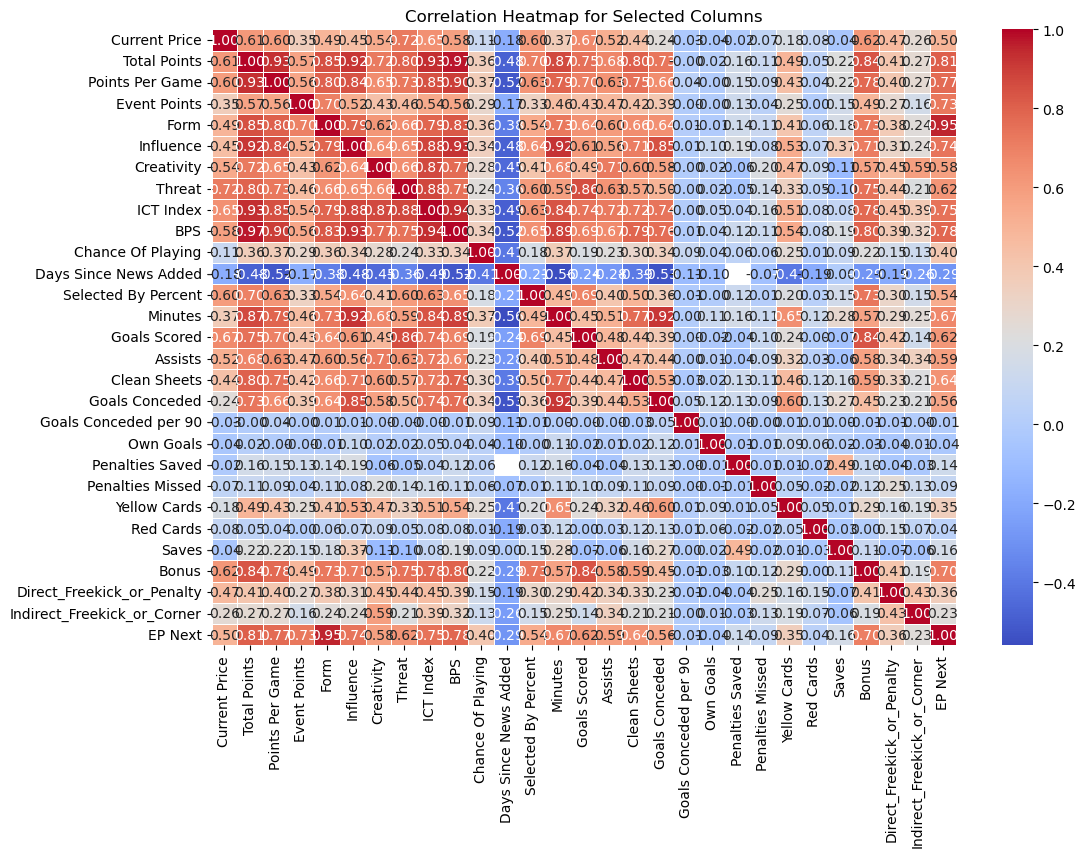

In [23]:
selected_columns = [
    'Name', 'Position', 'Team', 'Current Price', 'Total Points',
    'Points Per Game', 'Event Points', 'Form', 'Influence', 'Creativity', 'Threat', 'ICT Index', 
    'BPS', 'Chance Of Playing', 'News', 'Days Since News Added', 'Selected By Percent', 
    'Minutes', 'Goals Scored', 'Assists', 'Clean Sheets',
    'Goals Conceded', 'Goals Conceded per 90', 'Own Goals',
    'Penalties Saved', 'Penalties Missed', 'Yellow Cards', 'Red Cards',
    'Saves', 'Bonus', 
    'Direct_Freekick_or_Penalty', 'Indirect_Freekick_or_Corner', 'EP Next'
]


# Filter the DataFrame to include only the selected columns
selected_df = df[selected_columns]

# Calculate the correlation matrix for the selected columns
correlation_matrix = selected_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Selected Columns")
plt.show()

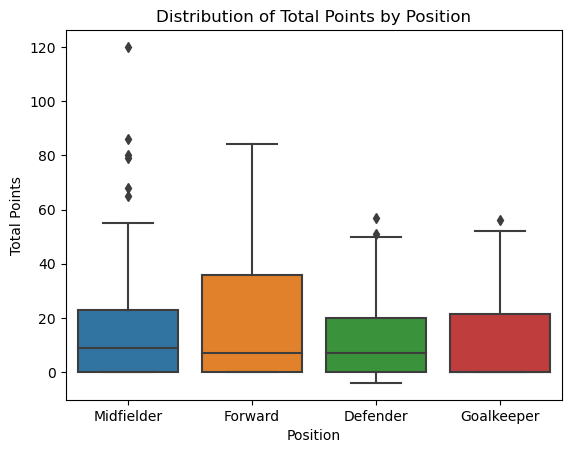

In [24]:
sns.boxplot(x='Position', y='Total Points', data=df)
plt.title("Distribution of Total Points by Position")
plt.show()

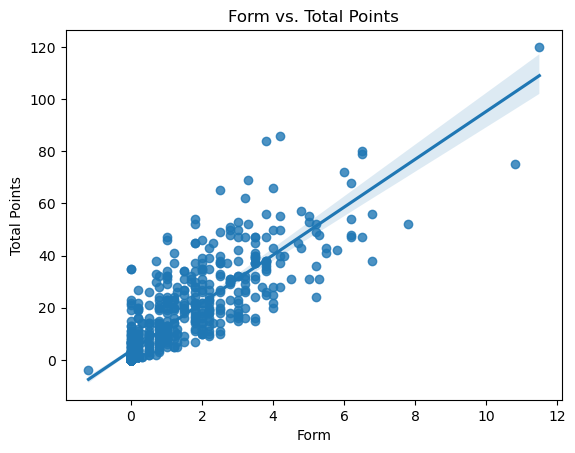

In [25]:
sns.regplot(x='Form', y='Total Points', data=df)
plt.title("Form vs. Total Points")
plt.show()

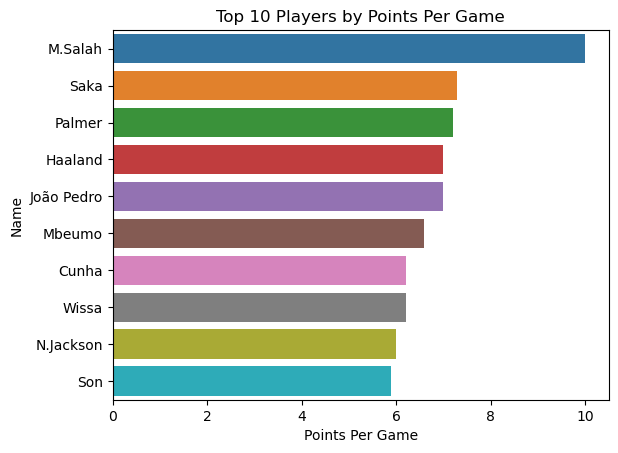

In [26]:
top_players = df.nlargest(10, 'Points Per Game')
sns.barplot(x='Points Per Game', y='Name', data=top_players)
plt.title("Top 10 Players by Points Per Game")
plt.show()

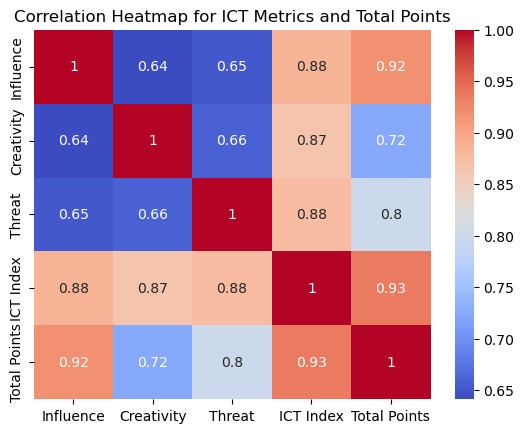

In [27]:
selected_columns = ['Influence', 'Creativity', 'Threat', 'ICT Index', 'Total Points']
sns.heatmap(df[selected_columns].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap for ICT Metrics and Total Points")
plt.show()

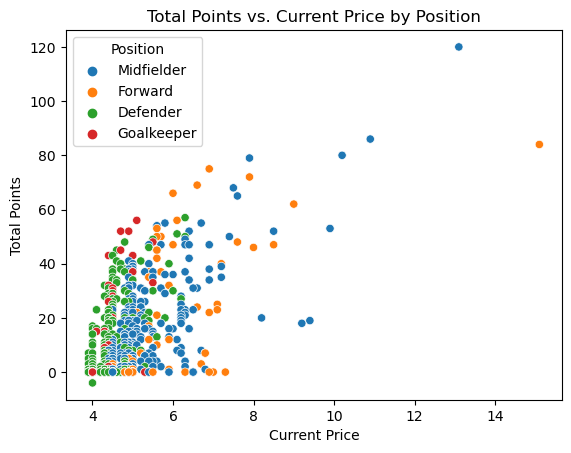

In [28]:
sns.scatterplot(x='Current Price', y='Total Points', hue='Position', data=df)
plt.title("Total Points vs. Current Price by Position")
plt.show()

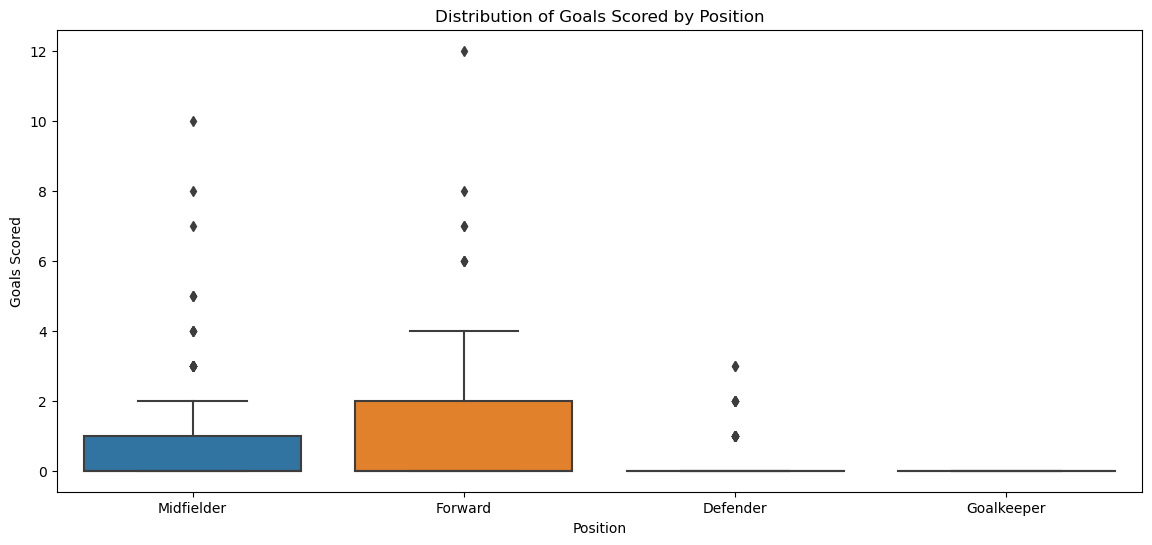

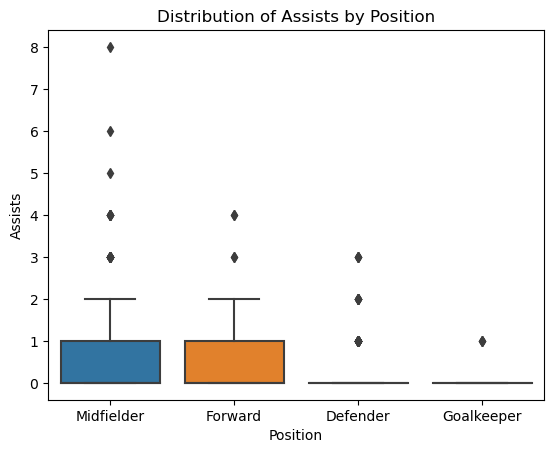

In [29]:
plt.figure(figsize=(14,6))
sns.boxplot(x='Position', y='Goals Scored', data=df)
plt.title("Distribution of Goals Scored by Position")
plt.show()

sns.boxplot(x='Position', y='Assists', data=df)
plt.title("Distribution of Assists by Position")
plt.show()

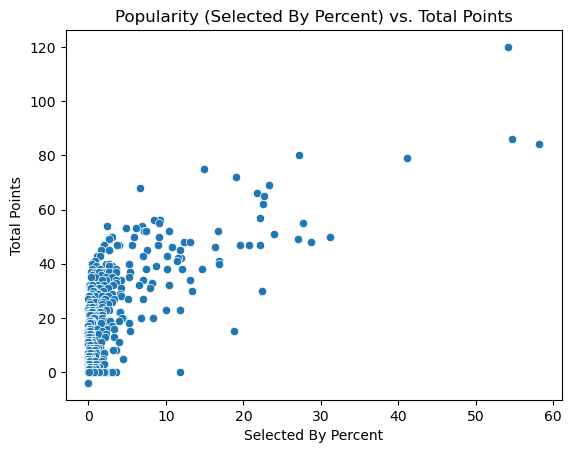

In [30]:
sns.scatterplot(x='Selected By Percent', y='Total Points', data=df)
plt.title("Popularity (Selected By Percent) vs. Total Points")
plt.show()

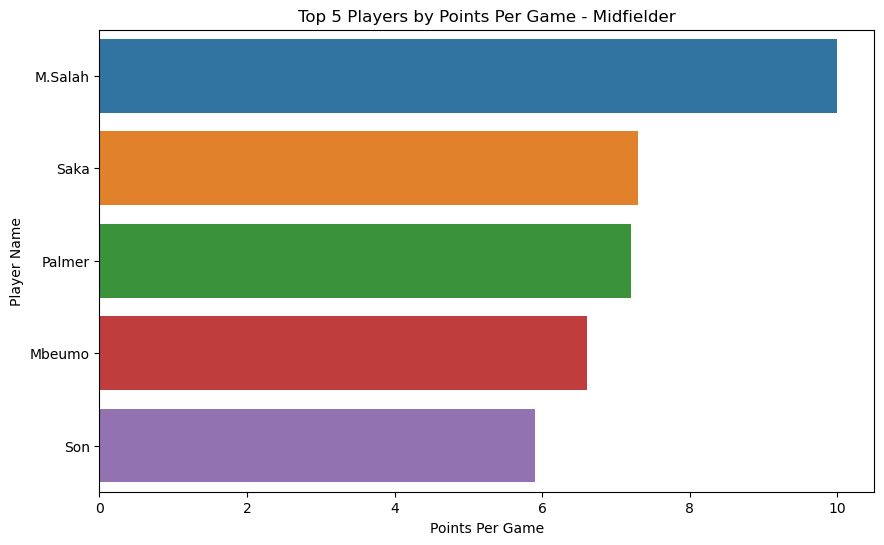

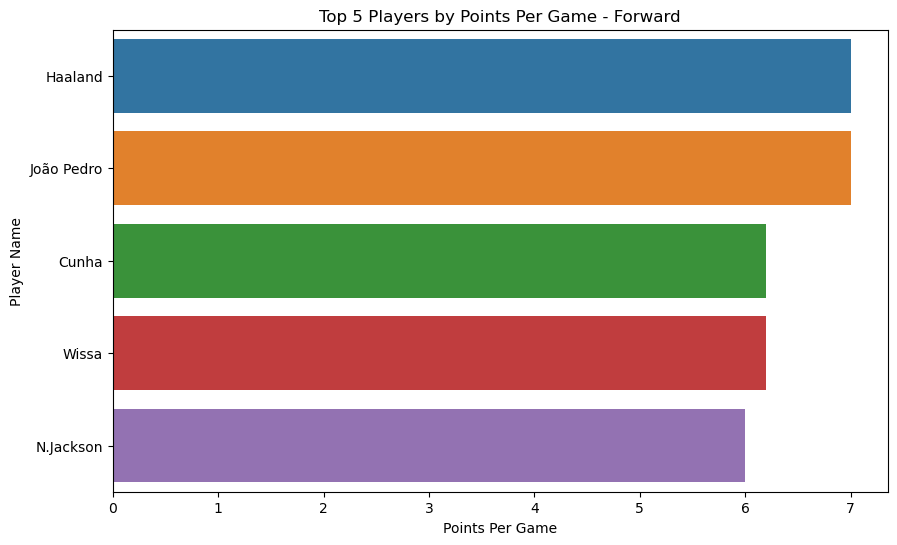

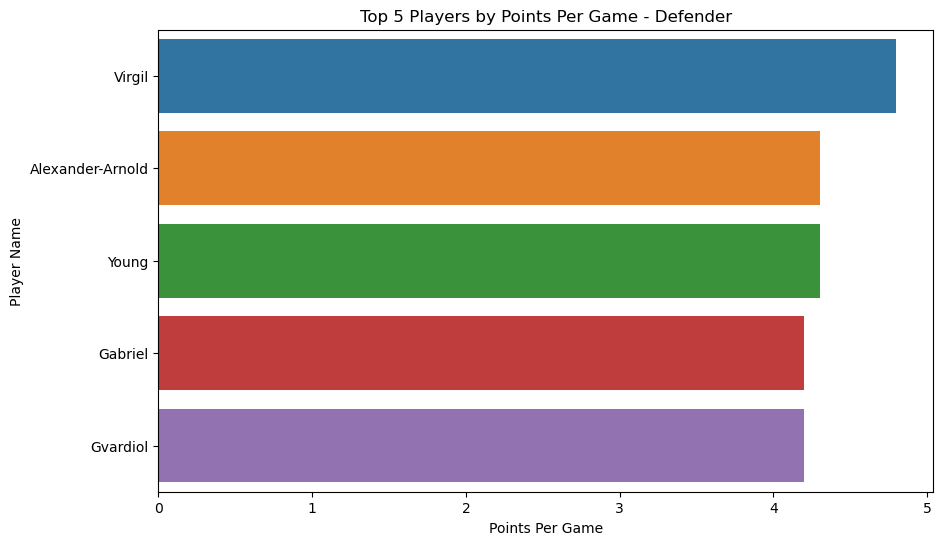

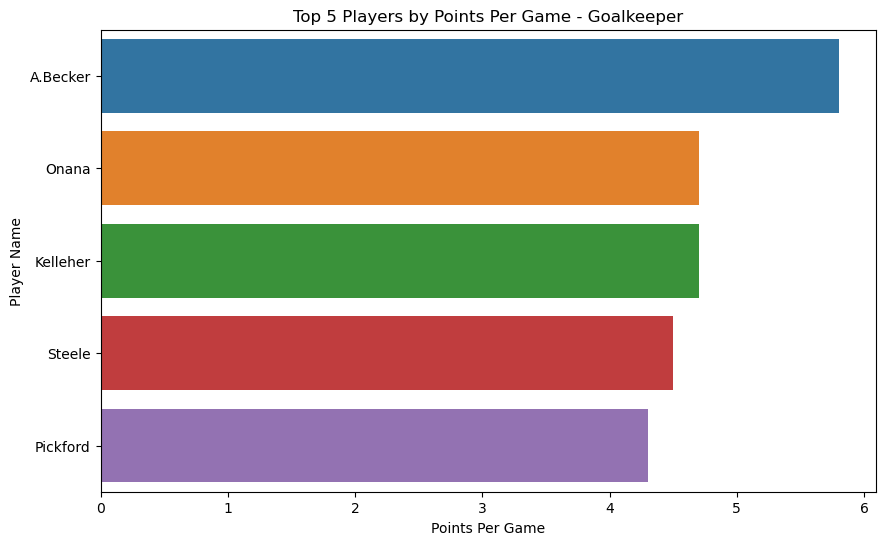

In [31]:
for position in df['Position'].unique():
    # Filter the top 10 players by 'Points Per Game' for the current position
    top_players = df[df['Position'] == position].nlargest(5, 'Points Per Game')
    
    # Create a bar plot for the top 10 players of the current position
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Points Per Game', y='Name', data=top_players)
    plt.title(f"Top 5 Players by Points Per Game - {position}")
    plt.xlabel("Points Per Game")
    plt.ylabel("Player Name")
    plt.show()